#***GRU***

In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, GRU
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from datetime import timedelta

# Đọc dữ liệu từ file CSV
file_path = '/content/BNB.csv'
data = pd.read_csv(file_path)

# Hiển thị một vài dòng đầu tiên của dữ liệu
data.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,3/1/2019,10.356931,11.607489,10.325634,11.393217,11.393217,117838677
1,3/2/2019,11.384693,11.915753,10.960816,11.869744,11.869744,120807894
2,3/3/2019,11.845305,11.964979,11.352064,11.537903,11.537903,89868246
3,3/4/2019,11.538013,11.599405,11.070543,11.545945,11.545945,89421231
4,3/5/2019,11.520388,13.841443,11.520388,13.811967,13.811967,237026335


#8:2

In [3]:
# Chỉ lấy cột giá đóng cửa
prices = data['Close'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

# Phân chia dữ liệu theo tỉ lệ 8:1:1
train_size = int(len(scaled_prices) * 0.8)
test_size = int(len(scaled_prices) * 0.2)

train, test = scaled_prices[0:train_size], scaled_prices[train_size:train_size+test_size]

print(f'train:{train_size}')
print(f'test:{test_size}')

# Hàm tạo các tập dữ liệu theo định dạng thích hợp cho mô hình GRU
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 60
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# Định dạng lại dữ liệu đầu vào cho mô hình GRU [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


train:1523
test:380


In [7]:
# Xây dựng mô hình GRU
model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(GRU(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=2)


Epoch 1/50
1462/1462 - 45s - loss: 0.0019 - 45s/epoch - 31ms/step
Epoch 2/50
1462/1462 - 45s - loss: 9.7584e-04 - 45s/epoch - 31ms/step
Epoch 3/50
1462/1462 - 37s - loss: 8.2874e-04 - 37s/epoch - 25ms/step
Epoch 4/50
1462/1462 - 35s - loss: 7.8515e-04 - 35s/epoch - 24ms/step
Epoch 5/50
1462/1462 - 43s - loss: 8.2700e-04 - 43s/epoch - 29ms/step
Epoch 6/50
1462/1462 - 37s - loss: 7.3855e-04 - 37s/epoch - 25ms/step
Epoch 7/50
1462/1462 - 37s - loss: 7.1281e-04 - 37s/epoch - 25ms/step
Epoch 8/50
1462/1462 - 35s - loss: 7.3177e-04 - 35s/epoch - 24ms/step
Epoch 9/50
1462/1462 - 39s - loss: 6.9860e-04 - 39s/epoch - 26ms/step
Epoch 10/50
1462/1462 - 38s - loss: 6.6432e-04 - 38s/epoch - 26ms/step
Epoch 11/50
1462/1462 - 35s - loss: 6.5933e-04 - 35s/epoch - 24ms/step
Epoch 12/50
1462/1462 - 36s - loss: 6.8480e-04 - 36s/epoch - 25ms/step
Epoch 13/50
1462/1462 - 56s - loss: 6.2139e-04 - 56s/epoch - 38ms/step
Epoch 14/50
1462/1462 - 54s - loss: 6.2358e-04 - 54s/epoch - 37ms/step
Epoch 15/50
1462/14

In [8]:
# Dự đoán trên tập test
test_predict = model.predict(X_test)

# Đảo ngược quá trình chuẩn hóa
test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform([y_test])

# Tính toán các chỉ số đánh giá
mse = mean_squared_error(y_test_actual[0], test_predict[:,0])
mae = mean_absolute_error(y_test_actual[0], test_predict[:,0])
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_actual[0] - test_predict[:,0]) / y_test_actual[0])) * 100

print("MAE: ",mae)
print("RMSE: ",rmse)
print("MAPE: ",mape)


10/10 [==============================] - 1s 14ms/step
MAE:  7.927790627924178
RMSE:  13.312649293357152
MAPE:  2.10808681493119


In [9]:
# Get the last 60 days of data for prediction
last_60_days = scaled_prices[-60:]

# Predict the next 30 days
next_30_days = []
for i in range(30):
    X_pred = last_60_days[-look_back:].reshape(1, look_back, 1)
    y_pred = model.predict(X_pred)
    next_30_days.append(y_pred[0,0])
    last_60_days = np.append(last_60_days, y_pred[0,0])
    last_60_days = last_60_days[1:]

# Predict the next 60 days
next_60_days = []
for i in range(60):
    X_pred = last_60_days[-look_back:].reshape(1, look_back, 1)
    y_pred = model.predict(X_pred)
    next_60_days.append(y_pred[0,0])
    last_60_days = np.append(last_60_days, y_pred[0,0])
    last_60_days = last_60_days[1:]

# Predict the next 90 days
next_90_days = []
for i in range(90):
    X_pred = last_60_days[-look_back:].reshape(1, look_back, 1)
    y_pred = model.predict(X_pred)
    next_90_days.append(y_pred[0,0])
    last_60_days = np.append(last_60_days, y_pred[0,0])
    last_60_days = last_60_days[1:]

# Inverse transform the predicted values
next_30_days_actual = scaler.inverse_transform(np.array(next_30_days).reshape(-1, 1))
next_60_days_actual = scaler.inverse_transform(np.array(next_60_days).reshape(-1, 1))
next_90_days_actual = scaler.inverse_transform(np.array(next_90_days).reshape(-1, 1))

print("Predicted prices for the next 30 days:")
print(next_30_days_actual.flatten())

print("\nPredicted prices for the next 60 days:")
print(next_60_days_actual.flatten())

print("\nPredicted prices for the next 90 days:")
print(next_90_days_actual.flatten())

1/1 [==============================] - 0s 31ms/step
Predicted prices for the next 30 days:
[557.5498  549.6992  540.6974  531.2469  523.9909  517.23004 510.6402
 505.10873 499.81628 494.65988 490.15353 485.95865 481.93164 478.2653
 474.82904 471.53934 468.47678 465.59805 462.85263 460.26352 457.81485
 455.47992 453.26254 451.15616 449.14618 447.22934 445.4013  443.65375
 441.98236 440.38345]

Predicted prices for the next 60 days:
[438.85205 437.38446 435.9774  434.6274  433.33124 432.0864  430.89008
 429.73962 428.63275 427.56735 426.54153 425.5532  424.60062 423.682
 422.796   421.9411  421.1159  420.31915 419.54965 418.80615 418.0876
 417.3929  416.72125 416.0715  415.44293 414.83466 414.24585 413.67587
 413.12396 412.58942 412.0715  411.56973 411.08347 410.61215 410.15518
 409.71213 409.2825  408.8658  408.4615  408.0693  407.68875 407.31943
 406.96097 406.61307 406.27524 405.94736 405.629   405.31976 405.01944
 404.72772 404.44424 404.16888 403.90137 403.6414  403.3889  403.14337


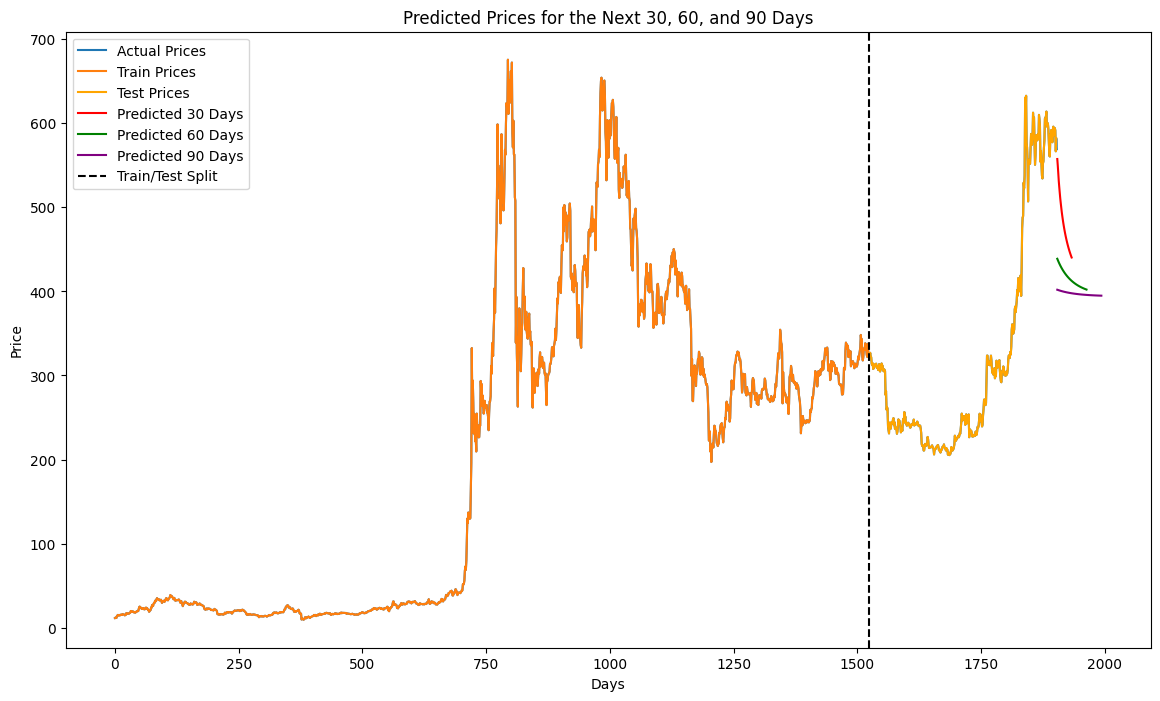

In [10]:
# Tính toán các ngày dự đoán
predict_days = [i for i in range(1, 91)]

# Vẽ biểu đồ gộp giá dự đoán 30, 60, và 90 ngày cùng với train và test
plt.figure(figsize=(14, 8))
plt.plot(range(len(prices)), prices, label='Actual Prices')
plt.plot(range(len(train)), scaler.inverse_transform(train), label='Train Prices')
plt.plot(range(len(train), len(train) + len(test)), scaler.inverse_transform(test), label='Test Prices', color='orange')
plt.plot(range(len(prices), len(prices) + 30), next_30_days_actual.flatten(), label='Predicted 30 Days', color='red')
plt.plot(range(len(prices), len(prices) + 60), next_60_days_actual.flatten(), label='Predicted 60 Days', color='green')
plt.plot(range(len(prices), len(prices) + 90), next_90_days_actual.flatten(), label='Predicted 90 Days', color='purple')
plt.axvline(x=len(train), color='black', linestyle='--', label='Train/Test Split')
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Predicted Prices for the Next 30, 60, and 90 Days')
plt.legend()
plt.show()

#7:3

In [11]:
# Chỉ lấy cột giá đóng cửa
prices = data['Close'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

# Phân chia dữ liệu theo tỉ lệ 7:3
train_size = int(len(scaled_prices) * 0.7)
test_size = int(len(scaled_prices) * 0.3)

train, test = scaled_prices[0:train_size], scaled_prices[train_size:train_size+test_size]

print(f'train:{train_size}')
print(f'test:{test_size}')

# Hàm tạo các tập dữ liệu theo định dạng thích hợp cho mô hình GRU
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 60
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# Định dạng lại dữ liệu đầu vào cho mô hình GRU [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


train:1332
test:571


In [12]:
# Xây dựng mô hình GRU
model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(GRU(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=2)


Epoch 1/50
1271/1271 - 36s - loss: 0.0026 - 36s/epoch - 29ms/step
Epoch 2/50
1271/1271 - 30s - loss: 0.0010 - 30s/epoch - 24ms/step
Epoch 3/50
1271/1271 - 30s - loss: 0.0011 - 30s/epoch - 24ms/step
Epoch 4/50
1271/1271 - 31s - loss: 8.3210e-04 - 31s/epoch - 25ms/step
Epoch 5/50
1271/1271 - 31s - loss: 8.8862e-04 - 31s/epoch - 25ms/step
Epoch 6/50
1271/1271 - 31s - loss: 8.4607e-04 - 31s/epoch - 24ms/step
Epoch 7/50
1271/1271 - 32s - loss: 7.5896e-04 - 32s/epoch - 25ms/step
Epoch 8/50
1271/1271 - 31s - loss: 8.9569e-04 - 31s/epoch - 25ms/step
Epoch 9/50
1271/1271 - 30s - loss: 7.6439e-04 - 30s/epoch - 24ms/step
Epoch 10/50
1271/1271 - 31s - loss: 7.6248e-04 - 31s/epoch - 24ms/step
Epoch 11/50
1271/1271 - 31s - loss: 7.2552e-04 - 31s/epoch - 24ms/step
Epoch 12/50
1271/1271 - 33s - loss: 7.1722e-04 - 33s/epoch - 26ms/step
Epoch 13/50
1271/1271 - 30s - loss: 7.5249e-04 - 30s/epoch - 24ms/step
Epoch 14/50
1271/1271 - 31s - loss: 7.2461e-04 - 31s/epoch - 24ms/step
Epoch 15/50
1271/1271 - 31s

In [13]:
# Dự đoán trên tập test
test_predict = model.predict(X_test)

# Đảo ngược quá trình chuẩn hóa
test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform([y_test])

# Tính toán các chỉ số đánh giá
mse = mean_squared_error(y_test_actual[0], test_predict[:,0])
mae = mean_absolute_error(y_test_actual[0], test_predict[:,0])
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_actual[0] - test_predict[:,0]) / y_test_actual[0])) * 100

print("MAE: ",mae)
print("RMSE: ",rmse)
print("MAPE: ",mape)


16/16 [==============================] - 1s 15ms/step
MAE:  7.917849851690795
RMSE:  11.882171789904723
MAPE:  2.331657717724007


In [14]:
# Get the last 60 days of data for prediction
last_60_days = scaled_prices[-60:]

# Predict the next 30 days
next_30_days = []
for i in range(30):
    X_pred = last_60_days[-look_back:].reshape(1, look_back, 1)
    y_pred = model.predict(X_pred)
    next_30_days.append(y_pred[0,0])
    last_60_days = np.append(last_60_days, y_pred[0,0])
    last_60_days = last_60_days[1:]

# Predict the next 60 days
next_60_days = []
for i in range(60):
    X_pred = last_60_days[-look_back:].reshape(1, look_back, 1)
    y_pred = model.predict(X_pred)
    next_60_days.append(y_pred[0,0])
    last_60_days = np.append(last_60_days, y_pred[0,0])
    last_60_days = last_60_days[1:]

# Predict the next 90 days
next_90_days = []
for i in range(90):
    X_pred = last_60_days[-look_back:].reshape(1, look_back, 1)
    y_pred = model.predict(X_pred)
    next_90_days.append(y_pred[0,0])
    last_60_days = np.append(last_60_days, y_pred[0,0])
    last_60_days = last_60_days[1:]

# Inverse transform the predicted values
next_30_days_actual = scaler.inverse_transform(np.array(next_30_days).reshape(-1, 1))
next_60_days_actual = scaler.inverse_transform(np.array(next_60_days).reshape(-1, 1))
next_90_days_actual = scaler.inverse_transform(np.array(next_90_days).reshape(-1, 1))

print("Predicted prices for the next 30 days:")
print(next_30_days_actual.flatten())

print("\nPredicted prices for the next 60 days:")
print(next_60_days_actual.flatten())

print("\nPredicted prices for the next 90 days:")
print(next_90_days_actual.flatten())

1/1 [==============================] - 0s 25ms/step
Predicted prices for the next 30 days:
[583.47974 594.2591  604.51886 614.52747 624.97284 633.0079  640.57166
 648.10876 654.10583 659.4391  664.6747  668.89844 672.50757 676.0151
 678.8641  681.22424 683.5091  685.37756 686.8839  688.34375 689.54846
 690.4943  691.4147  692.1834  692.771   693.34564 693.834   694.19635
 694.5525  694.86194]

Predicted prices for the next 60 days:
[695.08466 695.304   695.50006 695.6368  695.77124 695.8957  695.9797
 696.0616  696.14075 696.1924  696.242   696.29236 696.3243  696.35425
 696.3862  696.40625 696.42413 696.4448  696.45734 696.4679  696.4812
 696.48926 696.49554 696.50415 696.5094  696.5131  696.51874 696.5224
 696.5246  696.52844 696.5309  696.53235 696.53485 696.5366  696.5374
 696.5388  696.54    696.5403  696.5411  696.5416  696.5416  696.5421
 696.5425  696.5425  696.54266 696.5428  696.54266 696.54266 696.5426
 696.5424  696.5424  696.54236 696.54224 696.5422  696.5421  696.54193
 6

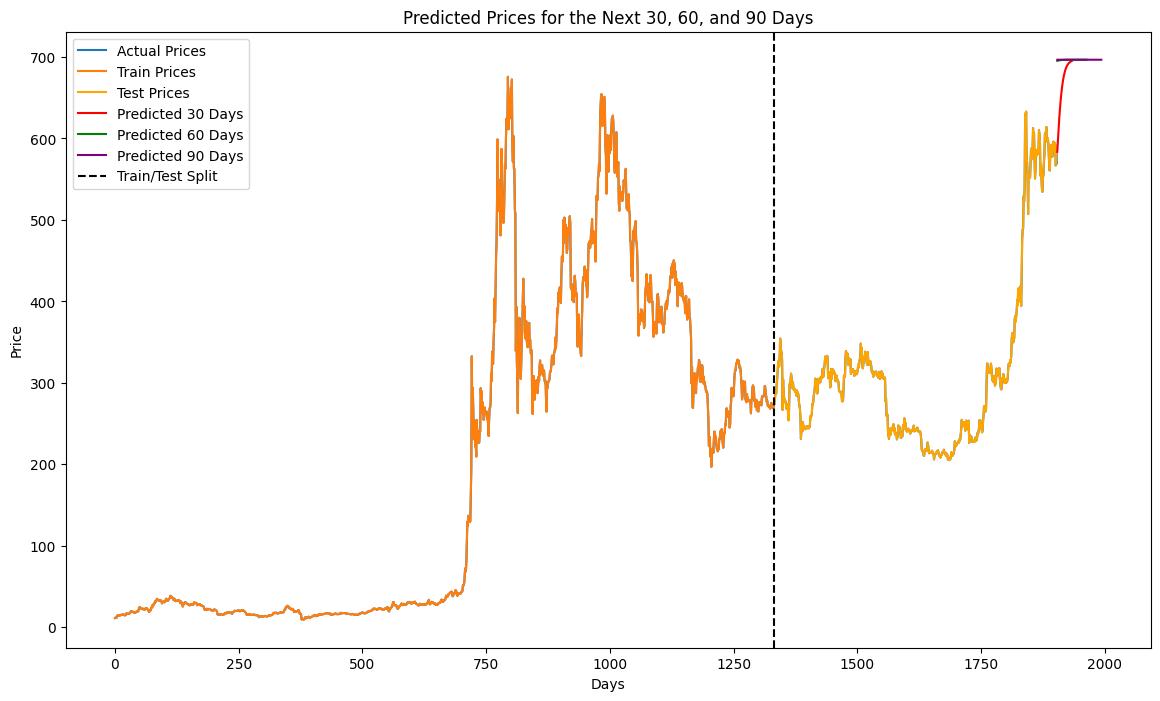

In [15]:
# Tính toán các ngày dự đoán
predict_days = [i for i in range(1, 91)]

# Vẽ biểu đồ gộp giá dự đoán 30, 60, và 90 ngày cùng với train và test
plt.figure(figsize=(14, 8))
plt.plot(range(len(prices)), prices, label='Actual Prices')
plt.plot(range(len(train)), scaler.inverse_transform(train), label='Train Prices')
plt.plot(range(len(train), len(train) + len(test)), scaler.inverse_transform(test), label='Test Prices', color='orange')
plt.plot(range(len(prices), len(prices) + 30), next_30_days_actual.flatten(), label='Predicted 30 Days', color='red')
plt.plot(range(len(prices), len(prices) + 60), next_60_days_actual.flatten(), label='Predicted 60 Days', color='green')
plt.plot(range(len(prices), len(prices) + 90), next_90_days_actual.flatten(), label='Predicted 90 Days', color='purple')
plt.axvline(x=len(train), color='black', linestyle='--', label='Train/Test Split')
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Predicted Prices for the Next 30, 60, and 90 Days')
plt.legend()
plt.show()

#6:4

In [16]:
# Chỉ lấy cột giá đóng cửa
prices = data['Close'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

# Phân chia dữ liệu theo tỉ lệ 6:2:2
train_size = int(len(scaled_prices) * 0.6)
test_size = int(len(scaled_prices) * 0.4)

train, test = scaled_prices[0:train_size], scaled_prices[train_size:train_size+test_size]

# Hàm tạo các tập dữ liệu theo định dạng thích hợp cho mô hình GRU
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 60
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# Định dạng lại dữ liệu đầu vào cho mô hình GRU [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [17]:
# Xây dựng mô hình GRU
model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(GRU(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=2)


Epoch 1/50
1081/1081 - 30s - loss: 0.0028 - 30s/epoch - 28ms/step
Epoch 2/50
1081/1081 - 26s - loss: 0.0011 - 26s/epoch - 24ms/step
Epoch 3/50
1081/1081 - 26s - loss: 0.0011 - 26s/epoch - 24ms/step
Epoch 4/50
1081/1081 - 27s - loss: 8.9535e-04 - 27s/epoch - 25ms/step
Epoch 5/50
1081/1081 - 26s - loss: 8.8350e-04 - 26s/epoch - 24ms/step
Epoch 6/50
1081/1081 - 28s - loss: 9.7320e-04 - 28s/epoch - 26ms/step
Epoch 7/50
1081/1081 - 26s - loss: 8.7819e-04 - 26s/epoch - 24ms/step
Epoch 8/50
1081/1081 - 27s - loss: 9.7082e-04 - 27s/epoch - 25ms/step
Epoch 9/50
1081/1081 - 27s - loss: 8.0298e-04 - 27s/epoch - 25ms/step
Epoch 10/50
1081/1081 - 26s - loss: 8.2252e-04 - 26s/epoch - 24ms/step
Epoch 11/50
1081/1081 - 26s - loss: 8.3280e-04 - 26s/epoch - 24ms/step
Epoch 12/50
1081/1081 - 28s - loss: 7.9281e-04 - 28s/epoch - 26ms/step
Epoch 13/50
1081/1081 - 26s - loss: 7.7035e-04 - 26s/epoch - 24ms/step
Epoch 14/50
1081/1081 - 26s - loss: 7.8684e-04 - 26s/epoch - 24ms/step
Epoch 15/50
1081/1081 - 26s

In [18]:
# Dự đoán trên tập test
test_predict = model.predict(X_test)

# Đảo ngược quá trình chuẩn hóa
test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform([y_test])

# Tính toán các chỉ số đánh giá
mse = mean_squared_error(y_test_actual[0], test_predict[:,0])
mae = mean_absolute_error(y_test_actual[0], test_predict[:,0])
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_actual[0] - test_predict[:,0]) / y_test_actual[0])) * 100

print("MAE: ",mae)
print("RMSE: ",rmse)
print("MAPE: ",mape)


22/22 [==============================] - 1s 13ms/step
MAE:  14.412872314492745
RMSE:  16.879223095104436
MAPE:  4.856239011961525


In [19]:
# Get the last 60 days of data for prediction
last_60_days = scaled_prices[-60:]

# Predict the next 30 days
next_30_days = []
for i in range(30):
    X_pred = last_60_days[-look_back:].reshape(1, look_back, 1)
    y_pred = model.predict(X_pred)
    next_30_days.append(y_pred[0,0])
    last_60_days = np.append(last_60_days, y_pred[0,0])
    last_60_days = last_60_days[1:]

# Predict the next 60 days
next_60_days = []
for i in range(60):
    X_pred = last_60_days[-look_back:].reshape(1, look_back, 1)
    y_pred = model.predict(X_pred)
    next_60_days.append(y_pred[0,0])
    last_60_days = np.append(last_60_days, y_pred[0,0])
    last_60_days = last_60_days[1:]

# Predict the next 90 days
next_90_days = []
for i in range(90):
    X_pred = last_60_days[-look_back:].reshape(1, look_back, 1)
    y_pred = model.predict(X_pred)
    next_90_days.append(y_pred[0,0])
    last_60_days = np.append(last_60_days, y_pred[0,0])
    last_60_days = last_60_days[1:]

# Inverse transform the predicted values
next_30_days_actual = scaler.inverse_transform(np.array(next_30_days).reshape(-1, 1))
next_60_days_actual = scaler.inverse_transform(np.array(next_60_days).reshape(-1, 1))
next_90_days_actual = scaler.inverse_transform(np.array(next_90_days).reshape(-1, 1))

print("Predicted prices for the next 30 days:")
print(next_30_days_actual.flatten())

print("\nPredicted prices for the next 60 days:")
print(next_60_days_actual.flatten())

print("\nPredicted prices for the next 90 days:")
print(next_90_days_actual.flatten())

1/1 [==============================] - 0s 35ms/step
Predicted prices for the next 30 days:
[589.37604 603.7057  616.84973 631.8468  644.0532  653.10895 664.2328
 672.4306  677.8341  686.33435 691.176   693.6954  700.861   702.82733
 703.24677 710.471   709.6022  708.66846 717.4337  713.2672  711.36035
 723.4356  714.9435  711.5878  727.45685 713.3824  705.7366  724.86566
 708.0234  697.26373]

Predicted prices for the next 60 days:
[715.3352  701.24554 690.4261  708.2166  704.08905 692.6208  710.41473
 696.5752  687.2091  705.1367  695.7035  686.5381  704.74976 718.318
 729.08563 739.516   749.38983 757.0003  763.0847  768.81104 772.7429
 775.2107  777.31354 778.3995  778.7515  778.99945 778.8673  778.44794
 745.8207  755.5434  757.401   730.5751  714.3552  699.1025  687.19543
 678.9354  672.71234 668.10803 665.01166 662.8543  661.3823  660.5488
 660.0734  659.8385  659.8394  659.9184  660.0524  660.2624  660.44556
 660.62317 660.8273  660.9787  661.1135  661.26874 661.37067 661.4603
 

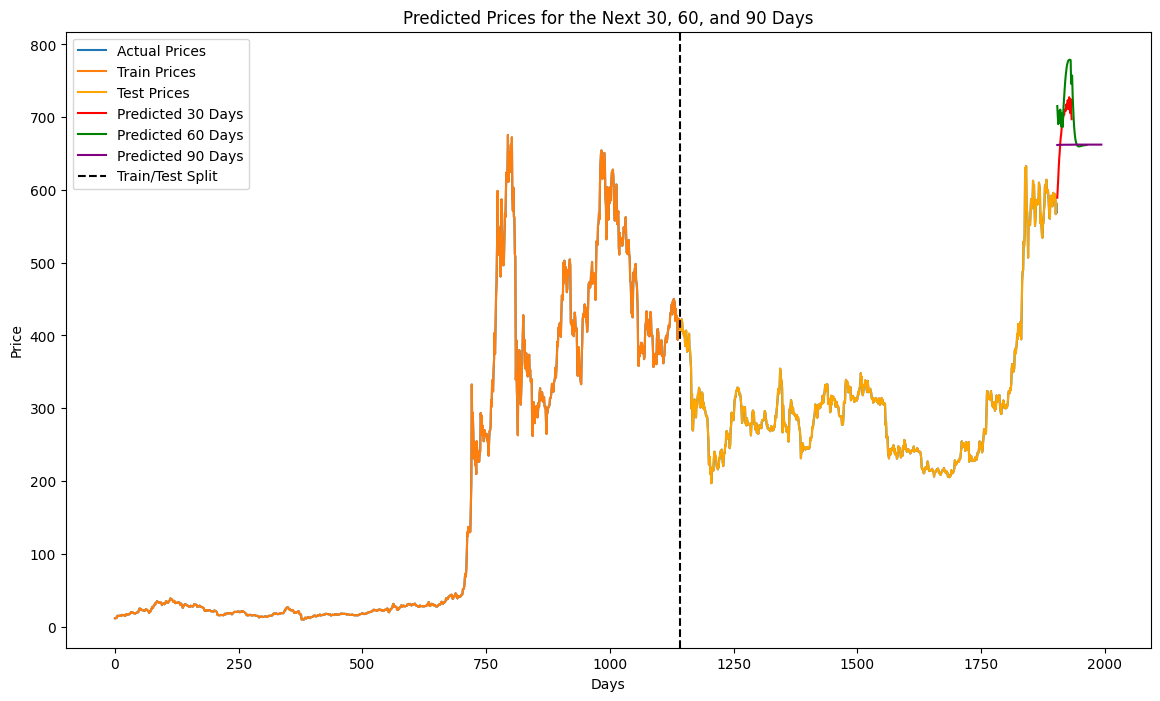

In [20]:
# Tính toán các ngày dự đoán
predict_days = [i for i in range(1, 91)]

# Vẽ biểu đồ gộp giá dự đoán 30, 60, và 90 ngày cùng với train và test
plt.figure(figsize=(14, 8))
plt.plot(range(len(prices)), prices, label='Actual Prices')
plt.plot(range(len(train)), scaler.inverse_transform(train), label='Train Prices')
plt.plot(range(len(train), len(train) + len(test)), scaler.inverse_transform(test), label='Test Prices', color='orange')
plt.plot(range(len(prices), len(prices) + 30), next_30_days_actual.flatten(), label='Predicted 30 Days', color='red')
plt.plot(range(len(prices), len(prices) + 60), next_60_days_actual.flatten(), label='Predicted 60 Days', color='green')
plt.plot(range(len(prices), len(prices) + 90), next_90_days_actual.flatten(), label='Predicted 90 Days', color='purple')
plt.axvline(x=len(train), color='black', linestyle='--', label='Train/Test Split')
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Predicted Prices for the Next 30, 60, and 90 Days')
plt.legend()
plt.show()